## Intro
Original GAN paper by Goodfellow et al.: https://arxiv.org/pdf/1406.2661.pdf  
Both generator and discriminator will be standard multilayer perceptrons (no convolutions just yet).

## Goals
<!-- checked: &#x2611; unchecked: &#x2610; -->
&#x2610; Implement working basic GAN on datasets from the paper (MNIST, TFD, CIFAR-10)  
&#x2610; Find a metric to compare with original data (some kind of similarity metric)  
&#x2610; Train and test on a new dataset and compare to the original

## Questions

#####  Is there any relationship between noise prior and training examples?  
Noise seems to be randomly chosen from the uniform distribution.

##### How to compare similarity between generated image and original images?
not even worth worrying

##### What is dimension of prior noise?
It's a parameter, could even be the same dimension as the training set.

In [ ]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

def mnist_std_mean():
    dataset = datasets.MNIST(root="./datasets", train=True, download=True)
    return torch.std_mean(dataset.data / 255.0)

#std, mean = mnist_std_mean()

t = transforms.Compose([transforms.ToTensor(),
                        transforms.Normalize(0.5, 0.5)])

#torch.manual_seed(7777)
mnist_train = datasets.MNIST(root="./datasets", train=True, download=True, transform=t)
mnist_test = datasets.MNIST(root="./datasets", train=False, download=True, transform=t)

In [ ]:
class MnistGenerator(torch.nn.Module):
    def __init__(self, nodim = 10):
        super(MnistGenerator, self).__init__()
        self.disc = None
        self.optim = None
        self.nodim = nodim
        
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.nodim, 256),
            torch.nn.LeakyReLU(0.2),
            
            torch.nn.Linear(256, 512),
            torch.nn.LeakyReLU(0.2),
            
            torch.nn.Linear(512, 1024),
            torch.nn.LeakyReLU(0.2),
            
            torch.nn.Linear(1024, 784),
            torch.nn.Tanh()
        )
    
    def init(self, disc, optimizer):
        self.disc = disc
        self.optim = optimizer
        
    def forward(self, z):
        return self.model(z)
    
    def loss(self, z):
        # converges super slow, seems like it makes no progress whatsoever
        #return torch.mean(1 - self.disc(self(z)), dim=0)
    
        # this should be better (according to the paper)
        # "-logD trick"
        return -torch.mean(torch.log(self.disc(self(z))), dim=0)

    def update(self, z):
        self.optim.zero_grad()
        x = self(z)
        l = self.disc.loss(self.disc(x), torch.ones(x.shape[0], 1))
        l.backward()
        self.optim.step()
        return l

In [ ]:
class MnistDiscriminator(torch.nn.Module):
    def __init__(self, criterion):
        super(MnistDiscriminator, self).__init__()
        self.gen = None
        self.optim = None
        self.criterion = criterion
        
        self.model = torch.nn.Sequential(
            torch.nn.Linear(784, 1024),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.3),
            
            torch.nn.Linear(1024, 512),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.3),
            
            torch.nn.Linear(512, 256),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.3),
            
            torch.nn.Linear(256, 1),
            torch.nn.Sigmoid()
        )
    
    def init(self, gen, optimizer):
        self.gen = gen
        self.optim = optimizer
    
    def forward(self, x: torch.Tensor):
        return self.model(x)
    
    def loss(self, x, label):
        return self.criterion(x, label)
        #return -torch.mean(label*torch.log(self(x)) + (1 - label)*torch.log(1 - self(self.gen(z))), dim=0)
    
    def update(self, data, noise):
        self.optim.zero_grad()
        true_loss = self.loss(self(data), torch.ones(data.shape[0], 1))
        true_loss.backward()
        
        prob = self(self.gen(noise).detach())
        false_loss = self.loss(prob, torch.zeros(data.shape[0], 1))
        false_loss.backward()
        
        self.optim.step()
        return true_loss + false_loss, prob

## Training algorithm

In [4]:
def gen_noise(batch_size, dim):
    return torch.randn(batch_size, dim)

def save_gen_mnist(name, size, figsize=(14,14)):
    noise = gen_noise(size, gen.nodim)
    test = gen(noise)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(torchvision.utils.make_grid(0.5*test.reshape(size, 1, 28, 28) + 0.5).detach().numpy().transpose(1, 2, 0), cmap="gray")
    fig.savefig(name)

In [20]:
import time

def train(gen, disc, trainloader, epochs=10, k=1, k2=1):
    stats = {'disc': {
        'losses': [],
        'probs': []
    }, 'gen': {
        'losses': [] 
    }}
    gen.model.train()
    disc.model.train()
    
    #trainiter = iter(trainloader)
    for i in range(epochs):
        begin = time.time()
        print(f"epoch: {i}/{epochs};" end=" ")
        
        discloss = 0
        probs = 0
        for j, (images, labels) in enumerate(iter(trainloader)):
            if j % 100 == 0:
                print(f"batch: {j}/{len(trainloader)}", end=" ")
            for _ in range(k):
                #try:
                #    images, labels = trainiter.next()
                #except StopIteration:
                #    trainiter = iter(trainloader)
                #    images, labels = trainiter.next()

                unwrapped = images[:,0,:,:].reshape(trainloader.batch_size, 784)
                noise = gen_noise(trainloader.batch_size, gen.nodim)

                l, p = disc.update(unwrapped, noise)
                discloss += l
                probs += p
        
            genloss = 0
            for _ in range(k2):
                noise = gen_noise(trainloader.batch_size, gen.nodim)
                genloss += gen.update(noise)
        #trainiter = iter(trainloader)
            
        #torch.autograd.set_detect_anomaly(True)
        stats['gen']['losses'].append(float(genloss.data / (k2 * len(trainloader))))
        stats['disc']['probs'].append(float(torch.mean(probs.data) / (2*k*len(trainloader))))
        stats['disc']['losses'].append(float(discloss / (2*k*len(trainloader))))
        end = time.time()
        print(f"prob: {round(stats['disc']['probs'][-1], 2)}, genloss: {round(stats['gen']['losses'][-1], 2)} " + 
        f"discloss: {round(stats['disc']['losses'][-1], 2)}, epoch_time: {round(end - begin, 2)} """, end="\r")
        if i % 2 == 0:
            save_gen_mnist("images/%d.png" % i, 8, figsize=(16, 16))
#     gen.model.train(mode=False)
#     disc.model.train(mode=False)
    return stats

0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.97.98.99.100.101.102.103.104.105.106.107.108.109.110.111.112.113.114.115.116.117.118.119.120.121.122.123.124.125.126.127.128.129.130.131.132.133.134.135.136.137.138.139.140.141.142.143.144.145.146.147.148.149.150.151.152.153.154.155.156.157.158.159.160.161.162.163.164.165.166.167.168.169.170.171.172.173.174.175.176.177.178.179.180.181.182.183.184.185.186.187.188.189.190.191.192.193.194.195.196.197.198.199.200.201.202.203.204.205.206.207.208.209.210.211.212.213.214.215.216.217.218.219.220.221.222.223.224.225.226.227.228.229.230.231.232.233.234.235.236.237.238.239.240.241.242.243.244.245.246.247.248.249.250.251.252.253.254.255.256.257.258.259.260.261.262.263.264.265.266.267.268.269.270.271.272.273.274.275.276.27

0.8.239.240.241.242.243.244.245.246.247.248.249.250.251.252.253.254.255.256.257.258.259.260.261.262.263.264.265.266.267.268.269.270.271.272.273.274.275.276.277.278.279.280.281.282.283.284.285.286.287.288.289.290.291.292.293.294.295.296.297.298.299.300.301.302.303.304.305.306.307.308.309.310.311.312.313.314.315.316.317.318.319.320.321.322.323.324.325.326.327.328.329.330.331.332.333.334.335.336.337.338.339.340.341.342.343.344.345.346.347.348.349.350.351.352.353.354.355.356.357.358.359.360.361.362.363.364.365.366.367.368.369.370.371.372.373.374.375.376.377.378.379.380.381.382.383.384.385.386.387.388.389.390.391.392.393.394.395.396.397.398.399.400.401.402.403.404.405.406.407.408.409.410.411.412.413.414.415.416.417.418.419.420.421.422.423.424.425.426.427.428.429.430.431.432.433.434.435.436.437.438.439.440.441.442.443.444.445.446.447.448.449.450.451.452.453.454.455.456.457.458.459.460.461.462.463.464.465.466.467.epoch: 4/200; prob: 41.13, genloss: 3.04 discloss: 131.23, epoch_time: 231.3 1.2

0.9.450.451.452.453.454.455.456.457.458.459.460.461.462.463.464.465.466.467.epoch: 8/200; prob: 52.12, genloss: 2.09 discloss: 164.79, epoch_time: 223.94 1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.97.98.99.100.101.102.103.104.105.106.107.108.109.110.111.112.113.114.115.116.117.118.119.120.121.122.123.124.125.126.127.128.129.130.131.132.133.134.135.136.137.138.139.140.141.142.143.144.145.146.147.148.149.150.151.152.153.154.155.156.157.158.159.160.161.162.163.164.165.166.167.168.169.170.171.172.173.174.175.176.177.178.179.180.181.182.183.184.185.186.187.188.189.190.191.192.193.194.195.196.197.198.199.200.201.202.203.204.205.206.207.208.209.210.211.212.213.214.215.216.217.218.219.220.221.222.223.224.225.226.227.228.229.230.231.232.233.234.235.236.237.238.23

0.9.200.201.202.203.204.205.206.207.208.209.210.211.212.213.214.215.216.217.218.219.220.221.222.223.224.225.226.227.228.229.230.231.232.233.234.235.236.237.238.239.240.241.242.243.244.245.246.247.248.249.250.251.252.253.254.255.256.257.258.259.260.261.262.263.264.265.266.267.268.269.270.271.272.273.274.275.276.277.278.279.280.281.282.283.284.285.286.287.288.289.290.291.292.293.294.295.296.297.298.299.300.301.302.303.304.305.306.307.308.309.310.311.312.313.314.315.316.317.318.319.320.321.322.323.324.325.326.327.328.329.330.331.332.333.334.335.336.337.338.339.340.341.342.343.344.345.346.347.348.349.350.351.352.353.354.355.356.357.358.359.360.361.362.363.364.365.366.367.368.369.370.371.372.373.374.375.376.377.378.379.380.381.382.383.384.385.386.387.388.389.390.391.392.393.394.395.396.397.398.399.400.401.402.403.404.405.406.407.408.409.410.411.412.413.414.415.416.417.418.419.420.421.422.423.424.425.426.427.428.429.430.431.432.433.434.435.436.437.438.439.440.441.442.443.444.445.446.447.448.

0.9.410.411.412.413.414.415.416.417.418.419.420.421.422.423.424.425.426.427.428.429.430.431.432.433.434.435.436.437.438.439.440.441.442.443.444.445.446.447.448.449.450.451.452.453.454.455.456.457.458.459.460.461.462.463.464.465.466.467.epoch: 17/200; prob: 77.72, genloss: 1.41 discloss: 232.61, epoch_time: 251.69 1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.97.98.99.100.101.102.103.104.105.106.107.108.109.110.111.112.113.114.115.116.117.118.119.120.121.122.123.124.125.126.127.128.129.130.131.132.133.134.135.136.137.138.139.140.141.142.143.144.145.146.147.148.149.150.151.152.153.154.155.156.157.158.159.160.161.162.163.164.165.166.167.168.169.170.171.172.173.174.175.176.177.178.179.180.181.182.183.184.185.186.187.188.189.190.191.192.193.194.195.196.197.198.1

0.0.161.162.163.164.165.166.167.168.169.170.171.172.173.174.175.176.177.178.179.180.181.182.183.184.185.186.187.188.189.190.191.192.193.194.195.196.197.198.199.200.201.202.203.204.205.206.207.208.209.210.211.212.213.214.215.216.217.218.219.220.221.222.223.224.225.226.227.228.229.230.231.232.233.234.235.236.237.238.239.240.241.242.243.244.245.246.247.248.249.250.251.252.253.254.255.256.257.258.259.260.261.262.263.264.265.266.267.268.269.270.271.272.273.274.275.276.277.278.279.280.281.282.283.284.285.286.287.288.289.290.291.292.293.294.295.296.297.298.299.300.301.302.303.304.305.306.307.308.309.310.311.312.313.314.315.316.317.318.319.320.321.322.323.324.325.326.327.328.329.330.331.332.333.334.335.336.337.338.339.340.341.342.343.344.345.346.347.348.349.350.351.352.353.354.355.356.357.358.359.360.361.362.363.364.365.366.367.368.369.370.371.372.373.374.375.376.377.378.379.380.381.382.383.384.385.386.387.388.389.390.391.392.393.394.395.396.397.398.399.400.401.402.403.404.405.406.407.408.409.

KeyboardInterrupt: 

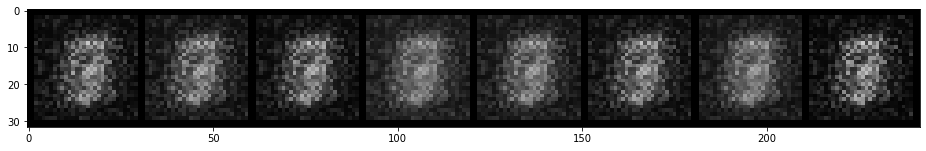

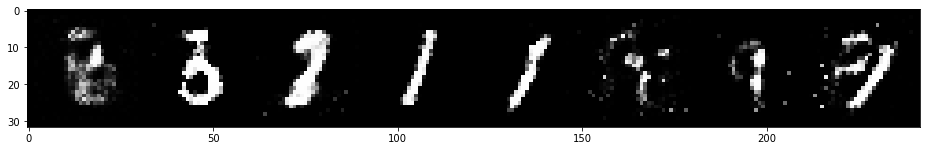

In [21]:
NOISE_DIM = 100
gen = MnistGenerator(nodim=NOISE_DIM)
disc = MnistDiscriminator(criterion=torch.nn.BCELoss())
gen.init(disc, torch.optim.Adam(gen.parameters(), lr=0.0002))
disc.init(gen, torch.optim.Adam(disc.parameters(), lr=0.0002))

mnist_trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=128, shuffle=True, num_workers=0, drop_last=True)

EPOCHS = 200
stats = train(gen, disc, mnist_trainloader, epochs=EPOCHS, k=2, k2=2)

fig, (p1, p2) = plt.subplots(2, 1, figsize=(16,26))
p1.plot(range(EPOCHS), stats["disc"]["losses"], color="blue")
p1.set_title("Loss")
p1.plot(range(EPOCHS), stats["gen"]["losses"], color="green")
#p2.set_title("Generator Loss")
p2.plot(range(EPOCHS), stats["disc"]["probs"], color="red")
p2.set_title("Discriminator Output")
plt.xlabel("epoch")
plt.ylabel("loss")

In [ ]:
mnist_testloader = torch.utils.data.DataLoader(mnist_test, batch_size=16, shuffle=True, num_workers=0)
testiter = iter(mnist_testloader)
img, label = testiter.next()

fig, ax = plt.subplots(figsize=(14,14))
ax.imshow(torchvision.utils.make_grid(0.5*img + 0.5).detach().numpy().transpose(1, 2, 0), cmap="gray")

#plt.imshow(img[0,0,:,:].numpy(), cmap="gray")
print(disc(img[:,0,:,:].reshape(16, 1, 784)).T)

In [ ]:
SAMPLE_SIZE = 56
noise = gen_noise(SAMPLE_SIZE, gen.nodim)
test = gen(noise)
fig, ax = plt.subplots(figsize=(14,14))
ax.imshow(torchvision.utils.make_grid(0.5*test.reshape(SAMPLE_SIZE, 1, 28, 28) + 0.5).detach().numpy().transpose(1, 2, 0), cmap="gray")

#plt.imshow(, cmap="gray")
#plt.imshow(test.detach().numpy().reshape(28, 28), cmap='gray')
print(disc(test).T)

## Problems:
- All noise seems to be collapsed into one pattern
- Discriminator seems to be too good
- Generator doesn't actually improve its results

I copied architecture from their implementation (https://github.com/goodfeli/adversarial/blob/master/mnist.yaml), but it still doesn't really work

## Links
- Introducing Goodfellow's NIPS Tutorial on GANS:
    - https://arxiv.org/abs/1701.00160
    - https://www.youtube.com/watch?v=HGYYEUSm-0Q
    
Good articles:
- http://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
- https://machinelearningmastery.com/how-to-code-the-generative-adversarial-network-training-algorithm-and-loss-functions/
- https://danieltakeshi.github.io/2017/03/05/understanding-generative-adversarial-networks/
- https://ai.stackexchange.com/questions/3488/understanding-gan-loss-function
- https://jonathan-hui.medium.com/gan-why-it-is-so-hard-to-train-generative-advisory-networks-819a86b3750b

Other articles where they recreate GANs:
- https://debuggercafe.com/generating-mnist-digit-images-using-vanilla-gan-with-pytorch/
= https://www.bigrabbitdata.com/pytorch-gan-1-generate-mnist-number-with-generative-adversarial-networkgans/#Load_Training_Dataset
- https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0

### To read
- https://rl-book.com/learn/statistics/kl_divergence/
- https://colah.github.io/posts/2015-09-Visual-Information/
- https://homes.cs.washington.edu/~ewein/blog/2020/07/14/entropy/ (discussion: https://news.ycombinator.com/item?id=23873752)
- https://longintuition.com/2020/07/20/max-entropy-intuition.html (discussion: https://news.ycombinator.com/item?id=23902712)
- https://arxiv.org/abs/1404.2000 (title: Notes on Kullback-Leibler Divergence and Likelihood)

# notes

## 2020-11-29
I think I missed `log` in generator's cost function. Switched to torch.BCELoss, which is much faster and it seems that the pattern is less random, but mode collapse is still there. Copied generator and discriminator architecture from [here](https://debuggercafe.com/generating-mnist-digit-images-using-vanilla-gan-with-pytorch/)

Trying some crazy huge discriminator, because it seems that it needs more expresiveness to catch generator's dirty trick of merging everything together.
Incorrect. This only seems to make it easier for the generator to fool the discriminator.

I need to somehow make discriminator better.